In [1]:
from pymongo import MongoClient
import pymongo
from bson.son import SON
import operator
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [2]:
# Connecting to DB
client=MongoClient()
client.database_names()

[u'lastfm_como',
 u'local',
 u'movies',
 u'new_songs_high_pop',
 u'songs_high_pop',
 u'songs_low_pop']

In [3]:
# Connecting to high popular songs database
db = client.new_songs_high_pop
db.collection_names()

[u'new_songs_high_pop']

In [4]:
# coll_all is the collection with all the fields in the songs_high_pop
coll_all= db.new_songs_high_pop

# Create a collection with reliable tags 

In [5]:
# We can create a collection where we remove the similar songs field from songs_high_pop
# and for the tags that have more than n% agreement, where n is a variable
coll_reliable = db.songs_ripped

In [6]:
# For all the songs in the original collection
for record in coll_all.find():
    #if record['']==[]: break
    new_record = {}
    
    # remove _id and similars fields
    del record["_id"] 
    del record["similars"]
    coll_reliable.insert_one(record)

In [7]:
# For all the songs in the coll_reliable collection, update the record to include truncated tag list 
# Modify variable n for different levels of reliability
n = 3
for record in coll_reliable.find():
    tags_modified = []
    for tag in record["tags"]:
        if tag[1] > n:
            tags_modified.append(tag)
    record["tags"] = tags_modified
    coll_reliable.update({"_id": record["_id"]}, record)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.


# Count the tags and find the prevailing ones

In [8]:
# Create a frequency dictionary of tags 
tags_count = {}

i = 0
tot = coll_reliable.count()

# Loop over each record in the collection
# Update the frequency of the <lowercased> tag
# If it does not exist add it to the dictionary 
for record in coll_reliable.find():
    
    tags = record["tags"]
    for elem in tags:
        tag, v =  elem[0].lower(), elem[1]
        
        try: 
            tags_count[tag] += 1.0
        except KeyError: 
            tags_count[tag] = 1.0
       
    # Anti-panic printing to monitor the progress
    if i % 10000 == 0:
        print i, tot
    i+=1

0 107810
10000 107810
20000 107810
30000 107810
40000 107810
50000 107810
60000 107810
70000 107810
80000 107810
90000 107810
100000 107810


In [9]:
# Sort the dictionary in descending order of the frequency
# Easier to find the minimum and maximum counts
sorted_tags_count = sorted(tags_count.items(), key=operator.itemgetter(1), reverse = True)

# Get the maximum and minimum count for normalising
max_count = sorted_tags_count[0][1]
min_count = min(data[1] for data in sorted_tags_count)

print max_count, min_count

# Create normalised frequency dictionary of tags
normalised_tags_count = {}
i = 0
tot = len(sorted_tags_count)

for entry in sorted_tags_count:
    tag, total_count =  entry[0], entry[1]
    normalised_tags_count[tag] = (total_count - min_count) / (max_count - min_count)
    
    # Anti-panic printing to monitor the progress
    if i % 10000 == 0:
        print i, tot
    i+=1

# Sort the normalised dictionary in descending order of the normalised frequency
sorted_normalised_tags = sorted(normalised_tags_count.items(), key=operator.itemgetter(1), reverse=True)


61988.0 1.0
0 330523
10000 330523
20000 330523
30000 330523
40000 330523
50000 330523
60000 330523
70000 330523
80000 330523
90000 330523
100000 330523
110000 330523
120000 330523
130000 330523
140000 330523
150000 330523
160000 330523
170000 330523
180000 330523
190000 330523
200000 330523
210000 330523
220000 330523
230000 330523
240000 330523
250000 330523
260000 330523
270000 330523
280000 330523
290000 330523
300000 330523
310000 330523
320000 330523
330000 330523


In [10]:
# Create a list of m prevailing tags on average (normalised)
prevailing_normalised_tags = []
m = 100

count = 1
for entry in sorted_normalised_tags:
    if entry[0] not in prevailing_normalised_tags:
        prevailing_normalised_tags.append(entry[0])
        count+=1
    if count > m:
        break


# Create matrix of song represented by tags (bag-of-tags)

In [11]:
# Create index for prevailing_normalised_tags for faster processing
tags_indexes = {}
for tag in prevailing_normalised_tags:
    tags_indexes[tag] = len(tags_indexes)
    

In [12]:
# Create matrix of song vectors
matrix_song_vectors = []
represented_song_ids = []

i = 0
tot = coll_reliable.count()

for record in coll_reliable.find():
    # create vector representation for each song
    # the columns are the prevailing tags tags
    record_vector = [0 for tag in prevailing_normalised_tags]
    
    flag = False
    for tag in record["tags"]:
        tag = tag[0].lower()
        try:
            index = tags_indexes[tag]
            record_vector[index] = 1
            flag = True
        except KeyError:
            continue
    
    # get those songs whose representation has at least one of the most m prevailing tags
    # get the represented song id to be later used for retrieval purposes in subsampling
    if flag:
        matrix_song_vectors.append(record_vector)
        represented_song_ids.append(record["_id"])
    
    # Anti-panic printing to monitor the progress
    if i % 10000 == 0:
        print i, tot
    i += 1

0 107810
10000 107810
20000 107810
30000 107810
40000 107810
50000 107810
60000 107810
70000 107810
80000 107810
90000 107810
100000 107810


# Calculate creativity score (cosine similarity) against mainstream popular song

In [13]:
# Create a vector that represents the mainstream popular (average creative) song
mainstream_song_vector = [0 for tag in prevailing_normalised_tags]

for song_vector in matrix_song_vectors:
    for i in range(len(song_vector)): mainstream_song_vector[i] += song_vector[i]

# Normalize the counts of the tags of the mainstream song vector by the size of the matrix
norm = float(len(matrix_song_vectors))
mainstream_song_vector = [tag_count/norm for tag_count in mainstream_song_vector]

# Format for numpy library
mainstream_song_vector = np.array(mainstream_song_vector)
mainstream_song_vector = mainstream_song_vector.reshape(1, -1)

print mainstream_song_vector

[[ 0.57697606  0.41902156  0.32431401  0.32105626  0.26799211  0.25027924
   0.20762128  0.20544324  0.20394467  0.20085446  0.19637738  0.19571652
   0.18333706  0.17378718  0.17299602  0.16358576  0.16078409  0.15683756
   0.15492014  0.14568673  0.14235452  0.14224282  0.14131204  0.13893853
   0.13503853  0.12663353  0.11444953  0.11391898  0.11325813  0.11297889
   0.10733832  0.10406195  0.09923117  0.0987937   0.09631781  0.09255743
   0.09126364  0.0903887   0.0894486   0.08704717  0.08647008  0.08393834
   0.07837224  0.07834432  0.0783257   0.07688298  0.0760732   0.07521687
   0.07427678  0.07190327  0.0714565   0.07140996  0.07125172  0.069446
   0.06794743  0.06738896  0.06705387  0.06662571  0.06532261  0.0648386
   0.0646059   0.06455006  0.06446629  0.06423359  0.06116199  0.06087345
   0.0604639   0.06004505  0.0599799   0.05899326  0.05847202  0.05784839
   0.05657322  0.05621021  0.05607059  0.05601474  0.05532596  0.05319446
   0.05308277  0.05243121  0.05231021  0.

In [14]:
# Calculate creativity scores for all the songs in the matrix
creativity_scores = []
tot = len(matrix_song_vectors)

for i in range(len(matrix_song_vectors)):
    
    song_vector = np.array(matrix_song_vectors[i])
    song_vector = song_vector.reshape(1, -1)
    creativity_scores.append(cosine_similarity(song_vector, mainstream_song_vector)[0][0])
    
    # Anti-panic printing to monitor the progress and the time taken
    if i % 10000 == 0:
        print i, tot 

0 107436
10000 107436
20000 107436
30000 107436
40000 107436
50000 107436
60000 107436
70000 107436
80000 107436
90000 107436
100000 107436


# Data visualisation

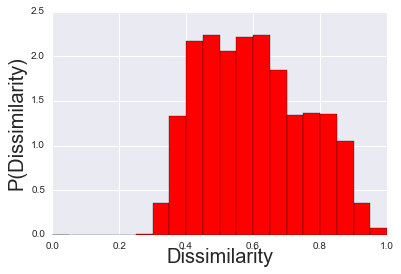

In [15]:
# Plot the creativity scores - they represent similarity between the mainstream popular song
import pylab as plt
import seaborn as sns

%matplotlib inline
creativity_scores = np.array(creativity_scores)
creativity_scores = 1 - creativity_scores 

h = plt.hist(creativity_scores, bins=[0.05*i for i in range(21)], normed=True, color='r')
plt.xlabel("Dissimilarity", fontsize=20, labelpad=-3)
plt.ylabel("P(Dissimilarity)", fontsize=20)
plt.savefig('disimilarity_histogram.png')

# Sampling the dataset for a uniform distribution of creativity score

In [16]:
# get the number of elements for each bin
bins=[0.05*i for i in range(21)]
# bin_ids_creativity_scores is an index array holding the bin id for each point in creativity_scores
bin_ids_creativity_scores = np.digitize(creativity_scores, bins)  

# create a frequency dictionary for the bin indexes
distribution_count = {}

for index in bin_ids_creativity_scores:
    try: 
        distribution_count[index] += 1.0
    except KeyError: 
        distribution_count[index] = 1.0

# Sort the dictionary in ascending order of the index frequency
sorted_distribution_count = sorted(distribution_count.items(), key=operator.itemgetter(1), reverse=False)

print sorted_distribution_count
print len(sorted_distribution_count)

[(6, 74.0), (20, 420.0), (7, 1895.0), (19, 1931.0), (18, 5620.0), (8, 7166.0), (15, 7183.0), (17, 7259.0), (16, 7319.0), (14, 9941.0), (11, 11072.0), (9, 11632.0), (12, 11885.0), (13, 11994.0), (10, 12045.0)]
15


In [17]:
# get the minimum number of samples from each bin to create a uniformly distributed sample
# in order to create more diverse sample, keep the minimum number the actual minimum
# for a more selective uniform distribution, decrease the number of bins involved 
# and increase the threshold for index count

# for example take the 9th bin and above 
# the threshold according to the above example is 11072
# create a uniformly distributed subsample from bins 9-13 (inclusive) taking 35147 songs from each
min_bin = 9
max_bin = 14
threshold = 11072

# dictionary to trace the number of songs added to the subsample per bin index
sample_distribution_count = {}
bins_to_be_subsampled = [b for b in range(min_bin, max_bin)]
tot = len(bin_ids_creativity_scores)
i = 0
subsample_song_ids = []
subsample_creativity_scores = []

for index in bin_ids_creativity_scores:
    
    if index in bins_to_be_subsampled:
        # get the song id belonging to the index if the frequency is less than the threshold
        
        try: 
            sample_distribution_count[index] += 1.0
        except KeyError: 
            sample_distribution_count[index] = 1.0
        
        if sample_distribution_count[index] <= threshold:
            subsample_song_ids.append(represented_song_ids[i])
            subsample_creativity_scores.append(creativity_scores[i])
    
    # Anti-panic printing to monitor the progress
    if i % 100000 == 0:
        print index, i, tot
    i += 1
    

15 0 107436
8 100000 107436


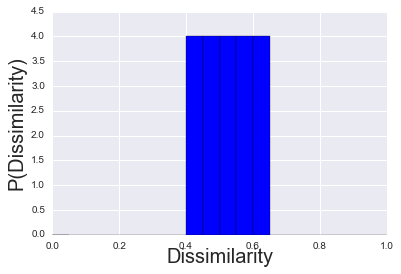

In [18]:
# Double check the histogram plot for the uniform distribution of the subsample
%matplotlib inline
subsample_creativity_scores = np.array(subsample_creativity_scores)

h2 = plt.hist(subsample_creativity_scores, bins=[0.05*i for i in range(21)], normed=True, color='b')
plt.xlabel("Dissimilarity", fontsize=20, labelpad=-3)
plt.ylabel("P(Dissimilarity)", fontsize=20)
plt.savefig('disimilarity_histogram_subsample.png')

In [19]:
# write this sample to csv to be given to the web interface
import csv
f = open("./songs_uniformly_sampled.csv", "w")
writer=csv.writer(f)
writer.writerow(["Album", "Song", "Artist", "Playcount"])
i = 0
tot = len(subsample_song_ids)

for idx in subsample_song_ids:
    record = coll_reliable.find_one({"_id":idx})
    l = [unicode(record["album"]).encode("utf-8")] + [record["name"]] + [record["artist"]] + [record["playcount"]]
    writer.writerow(l)
    
    # Anti-panic printing to monitor the progress
    if i % 10000 == 0:
        print i, tot
    i += 1
    
f.close()

0 55360
10000 55360
20000 55360
30000 55360
40000 55360
50000 55360


In [20]:
# Save the uniformly sampled mongo dump
coll_uniform = db.new_songs_uniform

i = 0
tot = len(subsample_song_ids)

for idx in subsample_song_ids:
    record = coll_reliable.find_one({"_id":idx})
    coll_uniform.insert_one(record)
    
    # Anti-panic printing to monitor the progress
    if i % 10000 == 0:
        print i, tot
    i += 1


0 55360
10000 55360
20000 55360
30000 55360
40000 55360
50000 55360
